##1. Our models are underperforming (not fitting the data well). What are 3 methods for preventing underfitting?
# Write them down and explain each with a sentence.

-Adicionar mais camadas, o modelo não capacidade suficiente para aprender o requerimento, padrões, pesos, etc. Um jeito de previvenir é adcionar mais poder predetivo para o modelo, isto é, aumentar o numero de camadas ocultas para aquelas camadas

-Usar menos regularização, Vai com calma nas tecnicas de regularização, pode ajudar ao seu model fit the data

-Treinar por mais tempo

##2. Recreate the data loading functions we built in sections 1, 2, 3 and 4.
#You should have train and test DataLoader's ready to use.


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision.models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tqdm import tqdm


device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Rodando na {device} \nPyTorch version: {torch.__version__}")

Rodando na cuda 
PyTorch version: 2.6.0+cu124


In [ ]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)

data/pizza_steak_sushi directory exists.


In [ ]:
import os
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory

  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [ ]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.


In [ ]:
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

Random image path: data/pizza_steak_sushi/train/sushi/1232045.jpg
Image class: sushi
Image height: 512
Image width: 512


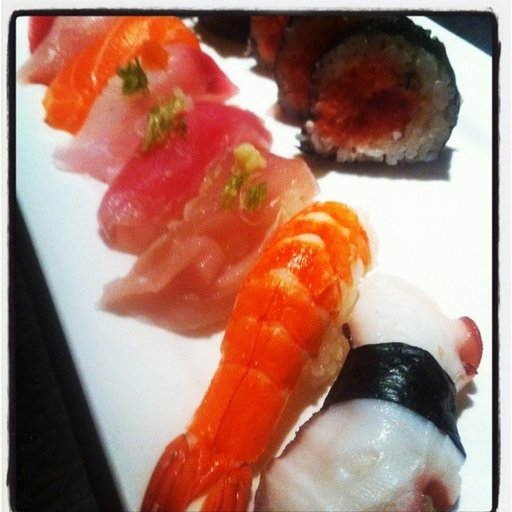

In [ ]:
import random
from PIL import Image

random.seed(42)

image_path_list = list(image_path.glob("*/*/*.jpg"))
random_image_path = random.choice(image_path_list)
image_class = random_image_path.parent.stem

img = Image.open(random_image_path)

print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")

img

Convertendo o dataset para array numpy

(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

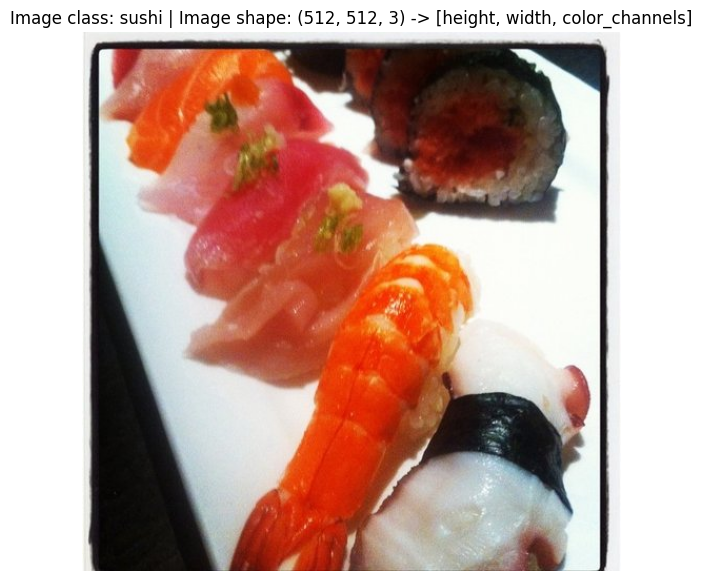

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

img_as_array = np.asarray(img)

plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False)

Transformando em dataloader

In [ ]:
data_t = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()

])

train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_t,
                                  target_transform=None)
test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_t)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data/pizza_steak_sushi/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


##3. Recreate model_0 we built in section 7.


In [ ]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=os.cpu_count())

test_loader = DataLoader(test_data, batch_size=32, shuffle=False, num_workers=os.cpu_count())


In [ ]:
class CNN_model(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
      nn.Conv2d(in_channels=input_shape,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1),
      nn.ReLU(),
      nn.Conv2d(in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2)
    )
    self.conv_block_2 = nn.Sequential(
      nn.Conv2d(in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1),
      nn.ReLU(),
      nn.Conv2d(in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2)
    )
    self.classifier = nn.Sequential(
      nn.Flatten(),
      nn.Linear(in_features=hidden_units*16*16,
                out_features=output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    x = self.conv_block_2(x)
    x = self.classifier(x)

    return x

In [ ]:
model_0 = CNN_model(input_shape=3, #rgb
                    hidden_units=10,
                    output_shape=10).to(device)

lossfunc = nn.CrossEntropyLoss()
optmizer = torch.optim.Adam(model_0.parameters(), lr= 1e-3)

model_0

CNN_model(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=10, bias=True)
  )
)

##4. Create training and testing functions for model_0.


In [ ]:
from tqdm import tqdm
import time

def train(model, dataloader, loss_func, optimizer, device):
  model.train()
  cumloss, train_acc = 0.0, 0.0

  for imgs, labels in tqdm(dataloader):
    imgs, labels = imgs.to(device), labels.to(device)

    pred = model(imgs)

    loss = lossfunc(pred, labels)
    cumloss += loss.item()

    optimizer.zero_grad()

    loss.backward()
    optimizer.step()

    #Calculo e acumulo de métricas de acurácia para todos os batches()
    y_pred_class = torch.argmax(torch.softmax(pred, dim=1), dim=1)
    train_acc += (y_pred_class == labels ).sum().item()/len(pred)

  train_loss = cumloss / len(dataloader)
  train_acc = train_acc / len(dataloader)

  return train_loss, train_acc

def test(model, dataloader, loss_func, device):
  model.eval()
  cumloss, test_acc = 0.0, 0.0

  with torch.no_grad():
    for imgs, labels in tqdm(dataloader):
      imgs, labels = imgs.to(device), labels.to(device)

      pred = model(imgs)
      loss = lossfunc(pred, labels)
      cumloss += loss.item()

      test_pred_labels = pred.argmax(dim=1)
      test_acc += ((test_pred_labels == labels ).sum().item()/len(test_pred_labels))

  test_loss = cumloss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_acc, test_loss

##5. Try training the model you made in exercise 3 for 5, 20 and 50 epochs, what happens to the results?
#Use torch.optim.Adam() with a learning rate of 0.001 as the optimizer.

In [ ]:
torch.manual_seed(42)
epochs= 100

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

temp_total = time.time()
for epoch in range(epochs):
    start_time = time.time()

    train_loss, train_acc = train(model_0, train_loader, lossfunc, optmizer, device)
    test_loss, test_acc = test(model_0, test_loader, lossfunc, device)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    epoch_time = time.time() - start_time

    print(f"Epoch: {epoch+1} | Tempo: {epoch_time:.2f}s")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2%}")
    print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2%}\n")
print(f"Total training time: {time.time()-temp_total:.3f} seconds")


100%|██████████| 3/3 [00:00<00:00,  4.15it/s]


Epoch: 1 | Tempo: 3.05s
Train Loss: 1.7059 | Train Acc: 40.62%
Test Loss: 0.2604 | Test Acc: 122.52%



100%|██████████| 3/3 [00:00<00:00,  5.25it/s]


Epoch: 2 | Tempo: 2.00s
Train Loss: 1.1296 | Train Acc: 42.58%
Test Loss: 0.2604 | Test Acc: 118.66%



100%|██████████| 3/3 [00:00<00:00,  5.67it/s]


Epoch: 3 | Tempo: 1.99s
Train Loss: 1.1439 | Train Acc: 30.08%
Test Loss: 0.3125 | Test Acc: 109.74%



100%|██████████| 3/3 [00:00<00:00,  4.77it/s]


Epoch: 4 | Tempo: 1.91s
Train Loss: 1.0872 | Train Acc: 35.55%
Test Loss: 0.2917 | Test Acc: 112.49%



100%|██████████| 3/3 [00:00<00:00,  5.92it/s]


Epoch: 5 | Tempo: 2.89s
Train Loss: 1.1212 | Train Acc: 33.20%
Test Loss: 0.3438 | Test Acc: 109.77%



100%|██████████| 3/3 [00:00<00:00, 10.37it/s]


Epoch: 6 | Tempo: 1.18s
Train Loss: 1.1225 | Train Acc: 36.33%
Test Loss: 0.2812 | Test Acc: 107.67%



100%|██████████| 3/3 [00:00<00:00, 10.53it/s]


Epoch: 7 | Tempo: 1.00s
Train Loss: 0.9933 | Train Acc: 48.05%
Test Loss: 0.2491 | Test Acc: 115.96%



100%|██████████| 3/3 [00:00<00:00, 10.29it/s]


Epoch: 8 | Tempo: 1.03s
Train Loss: 1.0801 | Train Acc: 34.77%
Test Loss: 0.3428 | Test Acc: 105.07%



100%|██████████| 3/3 [00:00<00:00,  9.92it/s]


Epoch: 9 | Tempo: 1.00s
Train Loss: 1.0496 | Train Acc: 44.14%
Test Loss: 0.2917 | Test Acc: 103.88%



100%|██████████| 3/3 [00:00<00:00,  9.56it/s]


Epoch: 10 | Tempo: 1.01s
Train Loss: 1.0627 | Train Acc: 41.80%
Test Loss: 0.5634 | Test Acc: 97.29%



100%|██████████| 3/3 [00:00<00:00,  9.74it/s]


Epoch: 11 | Tempo: 1.03s
Train Loss: 0.9949 | Train Acc: 42.58%
Test Loss: 0.3646 | Test Acc: 101.78%



100%|██████████| 3/3 [00:00<00:00,  9.76it/s]


Epoch: 12 | Tempo: 1.02s
Train Loss: 1.0061 | Train Acc: 46.88%
Test Loss: 0.3229 | Test Acc: 112.49%



100%|██████████| 3/3 [00:00<00:00,  9.60it/s]


Epoch: 13 | Tempo: 1.02s
Train Loss: 1.0154 | Train Acc: 41.80%
Test Loss: 0.5644 | Test Acc: 96.07%



100%|██████████| 3/3 [00:00<00:00,  7.69it/s]


Epoch: 14 | Tempo: 1.40s
Train Loss: 0.8775 | Train Acc: 61.72%
Test Loss: 0.3021 | Test Acc: 109.46%



100%|██████████| 3/3 [00:00<00:00,  6.18it/s]


Epoch: 15 | Tempo: 1.21s
Train Loss: 0.9854 | Train Acc: 45.70%
Test Loss: 0.2708 | Test Acc: 112.62%



100%|██████████| 3/3 [00:00<00:00,  6.31it/s]


Epoch: 16 | Tempo: 1.66s
Train Loss: 0.8737 | Train Acc: 63.28%
Test Loss: 0.3826 | Test Acc: 100.07%



100%|██████████| 3/3 [00:00<00:00, 10.30it/s]


Epoch: 17 | Tempo: 1.30s
Train Loss: 0.8537 | Train Acc: 65.23%
Test Loss: 0.2917 | Test Acc: 111.93%



100%|██████████| 3/3 [00:00<00:00, 10.37it/s]


Epoch: 18 | Tempo: 1.02s
Train Loss: 0.8569 | Train Acc: 64.06%
Test Loss: 0.3532 | Test Acc: 108.61%



100%|██████████| 3/3 [00:00<00:00, 10.45it/s]


Epoch: 19 | Tempo: 1.01s
Train Loss: 0.8316 | Train Acc: 64.06%
Test Loss: 0.3428 | Test Acc: 111.12%



100%|██████████| 3/3 [00:00<00:00, 10.30it/s]


Epoch: 20 | Tempo: 1.01s
Train Loss: 0.8250 | Train Acc: 67.19%
Test Loss: 0.3816 | Test Acc: 100.61%



100%|██████████| 3/3 [00:00<00:00, 10.56it/s]


Epoch: 21 | Tempo: 1.01s
Train Loss: 0.8780 | Train Acc: 48.44%
Test Loss: 0.4422 | Test Acc: 99.84%



100%|██████████| 3/3 [00:00<00:00, 10.77it/s]


Epoch: 22 | Tempo: 1.00s
Train Loss: 1.0148 | Train Acc: 48.83%
Test Loss: 0.4328 | Test Acc: 98.92%



100%|██████████| 3/3 [00:00<00:00, 10.40it/s]


Epoch: 23 | Tempo: 1.00s
Train Loss: 0.8198 | Train Acc: 60.16%
Test Loss: 0.5540 | Test Acc: 97.36%



100%|██████████| 3/3 [00:00<00:00, 10.24it/s]


Epoch: 24 | Tempo: 1.01s
Train Loss: 0.8676 | Train Acc: 57.81%
Test Loss: 0.5331 | Test Acc: 96.48%



100%|██████████| 3/3 [00:00<00:00, 10.11it/s]


Epoch: 25 | Tempo: 1.01s
Train Loss: 0.8431 | Train Acc: 66.80%
Test Loss: 0.4242 | Test Acc: 101.04%



100%|██████████| 3/3 [00:00<00:00,  9.68it/s]


Epoch: 26 | Tempo: 1.02s
Train Loss: 0.8473 | Train Acc: 51.95%
Test Loss: 0.3627 | Test Acc: 118.19%



100%|██████████| 3/3 [00:00<00:00,  6.10it/s]


Epoch: 27 | Tempo: 1.42s
Train Loss: 0.9577 | Train Acc: 59.38%
Test Loss: 0.4138 | Test Acc: 101.94%



100%|██████████| 3/3 [00:00<00:00,  6.67it/s]


Epoch: 28 | Tempo: 1.70s
Train Loss: 0.8711 | Train Acc: 55.08%
Test Loss: 0.5938 | Test Acc: 92.26%



100%|██████████| 3/3 [00:00<00:00,  9.22it/s]


Epoch: 29 | Tempo: 1.05s
Train Loss: 0.8523 | Train Acc: 48.44%
Test Loss: 0.5331 | Test Acc: 93.51%



100%|██████████| 3/3 [00:00<00:00,  9.81it/s]


Epoch: 30 | Tempo: 1.03s
Train Loss: 0.8121 | Train Acc: 71.48%
Test Loss: 0.5028 | Test Acc: 93.76%



100%|██████████| 3/3 [00:00<00:00, 10.02it/s]


Epoch: 31 | Tempo: 1.02s
Train Loss: 0.7788 | Train Acc: 71.48%
Test Loss: 0.3722 | Test Acc: 97.56%



100%|██████████| 3/3 [00:00<00:00,  9.89it/s]


Epoch: 32 | Tempo: 0.99s
Train Loss: 0.7357 | Train Acc: 69.53%
Test Loss: 0.4451 | Test Acc: 108.94%



100%|██████████| 3/3 [00:00<00:00, 10.21it/s]


Epoch: 33 | Tempo: 0.99s
Train Loss: 0.7855 | Train Acc: 68.75%
Test Loss: 0.4233 | Test Acc: 106.25%



100%|██████████| 3/3 [00:00<00:00,  9.61it/s]


Epoch: 34 | Tempo: 1.03s
Train Loss: 0.9001 | Train Acc: 57.42%
Test Loss: 0.3513 | Test Acc: 104.75%



100%|██████████| 3/3 [00:00<00:00, 10.60it/s]


Epoch: 35 | Tempo: 1.01s
Train Loss: 1.0756 | Train Acc: 58.20%
Test Loss: 0.4044 | Test Acc: 110.30%



100%|██████████| 3/3 [00:00<00:00, 10.24it/s]


Epoch: 36 | Tempo: 1.01s
Train Loss: 0.7655 | Train Acc: 70.31%
Test Loss: 0.5530 | Test Acc: 92.22%



100%|██████████| 3/3 [00:00<00:00, 10.14it/s]


Epoch: 37 | Tempo: 1.03s
Train Loss: 0.8244 | Train Acc: 60.16%
Test Loss: 0.5322 | Test Acc: 92.32%



100%|██████████| 3/3 [00:00<00:00,  8.23it/s]


Epoch: 38 | Tempo: 1.08s
Train Loss: 0.7767 | Train Acc: 67.97%
Test Loss: 0.4347 | Test Acc: 101.13%



100%|██████████| 3/3 [00:00<00:00,  5.69it/s]


Epoch: 39 | Tempo: 1.72s
Train Loss: 0.7324 | Train Acc: 68.36%
Test Loss: 0.3750 | Test Acc: 113.80%



100%|██████████| 3/3 [00:00<00:00,  9.92it/s]


Epoch: 40 | Tempo: 1.38s
Train Loss: 0.8079 | Train Acc: 57.03%
Test Loss: 0.4138 | Test Acc: 104.73%



100%|██████████| 3/3 [00:00<00:00, 10.23it/s]


Epoch: 41 | Tempo: 1.11s
Train Loss: 0.8360 | Train Acc: 53.91%
Test Loss: 0.3722 | Test Acc: 101.62%



100%|██████████| 3/3 [00:00<00:00, 10.23it/s]


Epoch: 42 | Tempo: 1.03s
Train Loss: 0.8107 | Train Acc: 57.81%
Test Loss: 0.5133 | Test Acc: 92.96%



100%|██████████| 3/3 [00:00<00:00,  9.68it/s]


Epoch: 43 | Tempo: 1.04s
Train Loss: 0.7750 | Train Acc: 66.02%
Test Loss: 0.4223 | Test Acc: 94.86%



100%|██████████| 3/3 [00:00<00:00, 10.16it/s]


Epoch: 44 | Tempo: 1.01s
Train Loss: 0.6979 | Train Acc: 71.88%
Test Loss: 0.3428 | Test Acc: 102.21%



100%|██████████| 3/3 [00:00<00:00,  9.45it/s]


Epoch: 45 | Tempo: 1.32s
Train Loss: 0.8435 | Train Acc: 55.08%
Test Loss: 0.3939 | Test Acc: 108.63%



100%|██████████| 3/3 [00:00<00:00,  9.81it/s]


Epoch: 46 | Tempo: 1.02s
Train Loss: 0.7881 | Train Acc: 71.48%
Test Loss: 0.3930 | Test Acc: 106.18%



100%|██████████| 3/3 [00:00<00:00,  9.97it/s]


Epoch: 47 | Tempo: 1.00s
Train Loss: 0.7880 | Train Acc: 69.53%
Test Loss: 0.4536 | Test Acc: 100.19%



100%|██████████| 3/3 [00:00<00:00,  9.82it/s]


Epoch: 48 | Tempo: 1.02s
Train Loss: 0.7784 | Train Acc: 71.09%
Test Loss: 0.3542 | Test Acc: 121.89%



100%|██████████| 3/3 [00:00<00:00,  8.94it/s]


Epoch: 49 | Tempo: 1.03s
Train Loss: 0.6933 | Train Acc: 68.36%
Test Loss: 0.3428 | Test Acc: 115.84%



100%|██████████| 3/3 [00:00<00:00,  6.37it/s]


Epoch: 50 | Tempo: 1.60s
Train Loss: 0.6799 | Train Acc: 72.66%
Test Loss: 0.4432 | Test Acc: 105.50%



100%|██████████| 3/3 [00:00<00:00,  8.99it/s]


Epoch: 51 | Tempo: 1.46s
Train Loss: 0.7193 | Train Acc: 60.16%
Test Loss: 0.3826 | Test Acc: 112.24%



100%|██████████| 3/3 [00:00<00:00,  9.50it/s]


Epoch: 52 | Tempo: 1.04s
Train Loss: 0.6667 | Train Acc: 72.66%
Test Loss: 0.3627 | Test Acc: 112.50%



100%|██████████| 3/3 [00:00<00:00, 10.40it/s]


Epoch: 53 | Tempo: 1.02s
Train Loss: 0.6140 | Train Acc: 74.22%
Test Loss: 0.4328 | Test Acc: 106.55%



100%|██████████| 3/3 [00:00<00:00, 10.56it/s]


Epoch: 54 | Tempo: 1.00s
Train Loss: 0.8045 | Train Acc: 65.23%
Test Loss: 0.3731 | Test Acc: 117.18%



100%|██████████| 3/3 [00:00<00:00, 10.36it/s]


Epoch: 55 | Tempo: 1.02s
Train Loss: 0.6576 | Train Acc: 72.66%
Test Loss: 0.3125 | Test Acc: 127.34%



100%|██████████| 3/3 [00:00<00:00, 10.22it/s]


Epoch: 56 | Tempo: 1.02s
Train Loss: 0.7380 | Train Acc: 74.61%
Test Loss: 0.4242 | Test Acc: 108.30%



100%|██████████| 3/3 [00:00<00:00, 10.10it/s]


Epoch: 57 | Tempo: 1.03s
Train Loss: 0.8410 | Train Acc: 55.86%
Test Loss: 0.4545 | Test Acc: 103.41%



100%|██████████| 3/3 [00:00<00:00, 10.42it/s]


Epoch: 58 | Tempo: 1.02s
Train Loss: 0.6505 | Train Acc: 71.09%
Test Loss: 0.3542 | Test Acc: 126.44%



100%|██████████| 3/3 [00:00<00:00, 10.31it/s]


Epoch: 59 | Tempo: 1.03s
Train Loss: 0.6974 | Train Acc: 75.00%
Test Loss: 0.3835 | Test Acc: 109.31%



100%|██████████| 3/3 [00:00<00:00, 10.11it/s]


Epoch: 60 | Tempo: 1.03s
Train Loss: 0.6253 | Train Acc: 75.78%
Test Loss: 0.4337 | Test Acc: 112.54%



100%|██████████| 3/3 [00:00<00:00,  5.99it/s]


Epoch: 61 | Tempo: 1.30s
Train Loss: 0.7413 | Train Acc: 64.06%
Test Loss: 0.4223 | Test Acc: 111.65%



100%|██████████| 3/3 [00:00<00:00,  6.77it/s]


Epoch: 62 | Tempo: 1.73s
Train Loss: 0.6256 | Train Acc: 77.34%
Test Loss: 0.3532 | Test Acc: 122.31%



100%|██████████| 3/3 [00:00<00:00,  9.21it/s]


Epoch: 63 | Tempo: 1.16s
Train Loss: 0.6972 | Train Acc: 71.09%
Test Loss: 0.3324 | Test Acc: 114.76%



100%|██████████| 3/3 [00:00<00:00,  9.99it/s]


Epoch: 64 | Tempo: 1.02s
Train Loss: 0.7740 | Train Acc: 62.89%
Test Loss: 0.4735 | Test Acc: 105.21%



100%|██████████| 3/3 [00:00<00:00,  9.87it/s]


Epoch: 65 | Tempo: 1.01s
Train Loss: 0.6401 | Train Acc: 76.56%
Test Loss: 0.4337 | Test Acc: 113.91%



100%|██████████| 3/3 [00:00<00:00,  9.69it/s]


Epoch: 66 | Tempo: 1.03s
Train Loss: 0.7633 | Train Acc: 59.38%
Test Loss: 0.4025 | Test Acc: 121.92%



100%|██████████| 3/3 [00:00<00:00, 10.18it/s]


Epoch: 67 | Tempo: 1.01s
Train Loss: 0.8150 | Train Acc: 67.97%
Test Loss: 0.5341 | Test Acc: 101.29%



100%|██████████| 3/3 [00:00<00:00,  7.72it/s]


Epoch: 68 | Tempo: 1.12s
Train Loss: 0.5670 | Train Acc: 80.47%
Test Loss: 0.4044 | Test Acc: 118.11%



100%|██████████| 3/3 [00:00<00:00, 10.25it/s]


Epoch: 69 | Tempo: 1.04s
Train Loss: 0.5821 | Train Acc: 75.39%
Test Loss: 0.4659 | Test Acc: 109.16%



100%|██████████| 3/3 [00:00<00:00, 10.02it/s]


Epoch: 70 | Tempo: 1.01s
Train Loss: 0.5630 | Train Acc: 77.73%
Test Loss: 0.4034 | Test Acc: 109.16%



100%|██████████| 3/3 [00:00<00:00,  9.98it/s]


Epoch: 71 | Tempo: 1.01s
Train Loss: 0.5537 | Train Acc: 79.30%
Test Loss: 0.4233 | Test Acc: 112.50%



100%|██████████| 3/3 [00:00<00:00,  8.01it/s]


Epoch: 72 | Tempo: 1.11s
Train Loss: 0.5713 | Train Acc: 81.25%
Test Loss: 0.4347 | Test Acc: 123.71%



100%|██████████| 3/3 [00:00<00:00,  6.28it/s]


Epoch: 73 | Tempo: 1.70s
Train Loss: 0.5717 | Train Acc: 74.61%
Test Loss: 0.4337 | Test Acc: 125.38%



100%|██████████| 3/3 [00:00<00:00, 10.06it/s]


Epoch: 74 | Tempo: 1.36s
Train Loss: 0.5318 | Train Acc: 79.30%
Test Loss: 0.4138 | Test Acc: 123.97%



100%|██████████| 3/3 [00:00<00:00, 10.14it/s]


Epoch: 75 | Tempo: 1.02s
Train Loss: 0.5264 | Train Acc: 77.73%
Test Loss: 0.4848 | Test Acc: 118.59%



100%|██████████| 3/3 [00:00<00:00, 10.20it/s]


Epoch: 76 | Tempo: 1.01s
Train Loss: 0.4835 | Train Acc: 80.47%
Test Loss: 0.4242 | Test Acc: 125.15%



100%|██████████| 3/3 [00:00<00:00, 10.10it/s]


Epoch: 77 | Tempo: 1.11s
Train Loss: 0.4816 | Train Acc: 82.03%
Test Loss: 0.4451 | Test Acc: 123.26%



100%|██████████| 3/3 [00:00<00:00,  7.87it/s]


Epoch: 78 | Tempo: 1.21s
Train Loss: 0.6026 | Train Acc: 69.92%
Test Loss: 0.5246 | Test Acc: 117.65%



100%|██████████| 3/3 [00:00<00:00, 10.55it/s]


Epoch: 79 | Tempo: 1.00s
Train Loss: 0.6235 | Train Acc: 65.23%
Test Loss: 0.5152 | Test Acc: 109.64%



100%|██████████| 3/3 [00:00<00:00, 10.03it/s]


Epoch: 80 | Tempo: 1.02s
Train Loss: 0.4696 | Train Acc: 82.03%
Test Loss: 0.4441 | Test Acc: 123.60%



100%|██████████| 3/3 [00:00<00:00, 10.01it/s]


Epoch: 81 | Tempo: 1.04s
Train Loss: 0.5153 | Train Acc: 80.08%
Test Loss: 0.4953 | Test Acc: 122.24%



100%|██████████| 3/3 [00:00<00:00, 10.14it/s]


Epoch: 82 | Tempo: 1.03s
Train Loss: 0.5477 | Train Acc: 82.03%
Test Loss: 0.4640 | Test Acc: 123.76%



100%|██████████| 3/3 [00:00<00:00,  9.94it/s]


Epoch: 83 | Tempo: 1.03s
Train Loss: 0.5698 | Train Acc: 77.73%
Test Loss: 0.4848 | Test Acc: 127.55%



100%|██████████| 3/3 [00:00<00:00,  5.88it/s]


Epoch: 84 | Tempo: 1.66s
Train Loss: 0.5442 | Train Acc: 82.03%
Test Loss: 0.4640 | Test Acc: 120.67%



100%|██████████| 3/3 [00:00<00:00,  8.98it/s]


Epoch: 85 | Tempo: 1.47s
Train Loss: 0.5386 | Train Acc: 80.08%
Test Loss: 0.5256 | Test Acc: 122.85%



100%|██████████| 3/3 [00:00<00:00, 10.14it/s]


Epoch: 86 | Tempo: 1.02s
Train Loss: 0.4556 | Train Acc: 78.91%
Test Loss: 0.5047 | Test Acc: 146.56%



100%|██████████| 3/3 [00:00<00:00, 10.33it/s]


Epoch: 87 | Tempo: 1.02s
Train Loss: 0.4318 | Train Acc: 81.25%
Test Loss: 0.4337 | Test Acc: 149.63%



100%|██████████| 3/3 [00:00<00:00,  9.69it/s]


Epoch: 88 | Tempo: 1.04s
Train Loss: 0.3926 | Train Acc: 84.77%
Test Loss: 0.5360 | Test Acc: 129.96%



100%|██████████| 3/3 [00:00<00:00,  9.99it/s]


Epoch: 89 | Tempo: 1.01s
Train Loss: 0.3901 | Train Acc: 85.94%
Test Loss: 0.5559 | Test Acc: 127.72%



100%|██████████| 3/3 [00:00<00:00,  9.80it/s]


Epoch: 90 | Tempo: 1.08s
Train Loss: 0.3655 | Train Acc: 85.94%
Test Loss: 0.5350 | Test Acc: 127.02%



100%|██████████| 3/3 [00:00<00:00, 10.07it/s]


Epoch: 91 | Tempo: 1.03s
Train Loss: 0.4088 | Train Acc: 84.77%
Test Loss: 0.4347 | Test Acc: 143.30%



100%|██████████| 3/3 [00:00<00:00,  6.35it/s]


Epoch: 92 | Tempo: 1.64s
Train Loss: 0.4124 | Train Acc: 84.38%
Test Loss: 0.5246 | Test Acc: 139.84%



100%|██████████| 3/3 [00:00<00:00,  9.95it/s]


Epoch: 93 | Tempo: 1.31s
Train Loss: 0.4878 | Train Acc: 84.38%
Test Loss: 0.4640 | Test Acc: 127.23%



100%|██████████| 3/3 [00:00<00:00,  5.79it/s]


Epoch: 94 | Tempo: 1.27s
Train Loss: 0.3934 | Train Acc: 85.16%
Test Loss: 0.5057 | Test Acc: 126.91%



100%|██████████| 3/3 [00:00<00:00,  5.86it/s]


Epoch: 95 | Tempo: 1.79s
Train Loss: 0.3600 | Train Acc: 86.33%
Test Loss: 0.5455 | Test Acc: 130.60%



100%|██████████| 3/3 [00:00<00:00,  9.99it/s]


Epoch: 96 | Tempo: 1.14s
Train Loss: 0.4345 | Train Acc: 76.17%
Test Loss: 0.4650 | Test Acc: 141.10%



100%|██████████| 3/3 [00:00<00:00,  9.79it/s]


Epoch: 97 | Tempo: 1.03s
Train Loss: 0.5133 | Train Acc: 71.48%
Test Loss: 0.5758 | Test Acc: 121.18%



100%|██████████| 3/3 [00:00<00:00,  9.75it/s]


Epoch: 98 | Tempo: 1.06s
Train Loss: 0.4595 | Train Acc: 80.86%
Test Loss: 0.5966 | Test Acc: 120.43%



100%|██████████| 3/3 [00:00<00:00, 10.14it/s]


Epoch: 99 | Tempo: 1.03s
Train Loss: 0.4075 | Train Acc: 86.72%
Test Loss: 0.4555 | Test Acc: 140.81%



100%|██████████| 3/3 [00:00<00:00, 10.12it/s]

Epoch: 100 | Tempo: 1.03s
Train Loss: 0.4549 | Train Acc: 82.03%
Test Loss: 0.5464 | Test Acc: 140.28%

Total training time: 1.026 seconds


In [ ]:
def plot_loss_curves(train_loss, train_acc,test_loss, test_acc):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """

    # Figure out how many epochs there were
    epochs = range(len(train_loss))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label='train_accuracy')
    plt.plot(epochs, test_acc, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

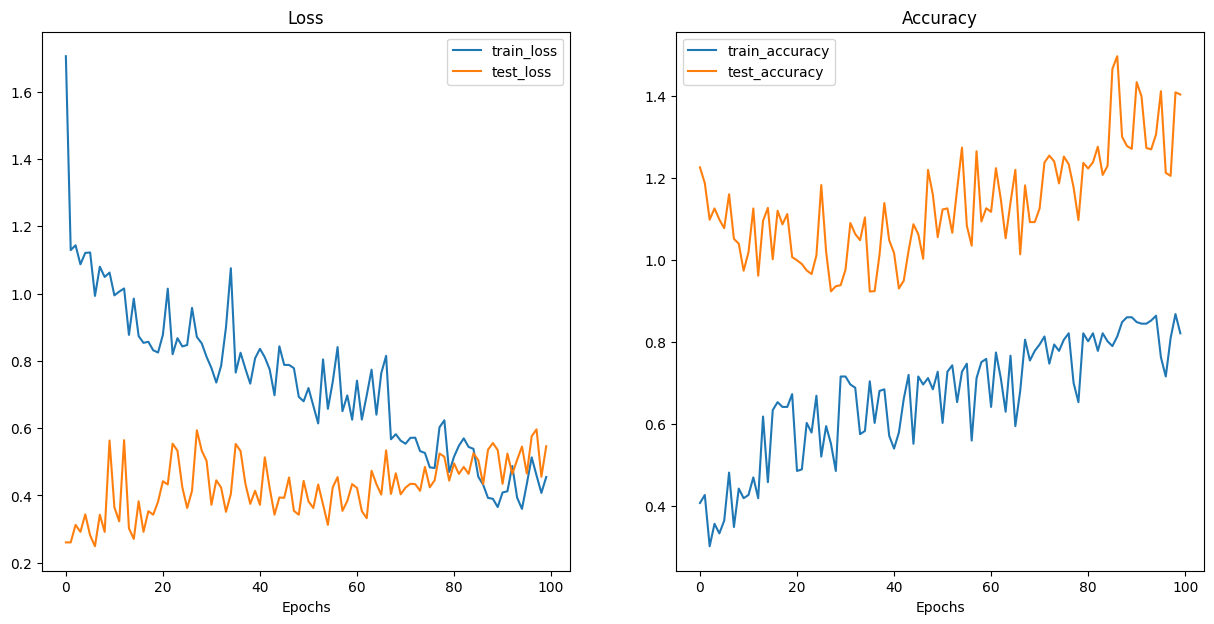

In [ ]:
plot_loss_curves(train_losses, train_accuracies, test_losses, test_accuracies)

##6. Double the number of hidden units in your model and train it for 20 epochs, what happens to the results?

In [ ]:
model_1 = CNN_model(input_shape=3, #rgb
                    hidden_units=20,
                    output_shape=10).to(device)

lossfunc = nn.CrossEntropyLoss()
optmizer = torch.optim.Adam(model_0.parameters(), lr= 0.001)

model_1

In [ ]:
torch.manual_seed(42)
epochs= 20

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(epochs):
    start_time = time.time()

    train_loss, train_acc = train(model_1, train_loader, lossfunc, optmizer, device)
    test_loss, test_acc = test(model_1, test_loader, lossfunc, device)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    epoch_time = time.time() - start_time

    print(f"Epoch: {epoch+1} | Tempo: {epoch_time:.2f}s")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2%}")
    print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2%}\n")
print(f"Total training time: {time.time()-start_time:.3f} seconds")


##7. Double the data you're using with your model and train it for 20 epochs, what happens to the results?
Note: You can use the custom data creation notebook to scale up your Food101 dataset.
You can also find the already formatted double data (20% instead of 10% subset) dataset on GitHub, you will need to write download code like in exercise 2 to get it into this notebook.

In [ ]:
double_d = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

train_data_1 = datasets.ImageFolder(root=train_dir,
                                  transform=double_d,
                                  target_transform=None)
test_data_1 = datasets.ImageFolder(root=test_dir,
                                 transform=double_d)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

In [ ]:
train_loader = DataLoader(train_data_1, batch_size=32, shuffle=True, num_workers=os.cpu_count())

test_loader = DataLoader(test_data_1, batch_size=32, shuffle=False, num_workers=os.cpu_count())

In [ ]:
torch.manual_seed(42)
epochs= 20

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(epochs):
    start_time = time.time()

    train_loss, train_acc = train(model_0, train_loader, lossfunc, optmizer, device)
    test_loss, test_acc = test(model_0, test_loader, lossfunc, device)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    epoch_time = time.time() - start_time

    print(f"Epoch: {epoch+1} | Tempo: {epoch_time:.2f}s")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2%}")
    print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2%}\n")
print(f"Total training time: {time.time()-start_time:.3f} seconds")


##8. Make a prediction on your own custom image of pizza/steak/sushi (you could even download one from the internet) and share your prediction.
Does the model you trained in exercise 7 get it right?
If not, what do you think you could do to improve it?

In [ ]:
#https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb - dar uma olhada nisso para resolver essa parte do ex